<a href="https://colab.research.google.com/github/ozturkgizem/042422/blob/main/SeaIcePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***VERİYE ERİŞİM (GET DATA)***

In [34]:
import matplotlib
import pandas
import statsmodels
import imageio

matplotlib.use("AGG")
import numpy as np
from pylab import *
import numpy.ma as ma
from glob import glob
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
import argparse # for passing variables from bash
import sys
sys.path.append('./')
from scipy.interpolate import griddata

from scipy.io import netcdf
from matplotlib import rc
import matplotlib.patches as patches

import argparse # for passing variables from bash

import os

In [35]:
#!pip install numpy==1.20.0

In [ ]:
!pip install basemap

In [37]:
from mpl_toolkits.basemap import Basemap, shiftgrid

In [38]:
#!pip install netCDF4==1.4.1
from netCDF4 import Dataset

In [ ]:
!git clone https://github.com/akpetty/SeaIcePrediction.git  Github

In [ ]:
!git clone https://github.com/ozturkgizem/042422.git Gizem

In [41]:
#non-compatible w the other dir
datapath= "./SeaIce2022/ICE_CONC/NASA_TEAM"
if not os.path.exists(datapath):
	os.makedirs(os.path.join(datapath))
!cp -r ./Gizem/ICE_CONC/ARCTIC/ ./SeaIce2022/ICE_CONC/NASA_TEAM/
!cp -r ./Gizem/ICE_CONC/ANTARCTIC/ ./SeaIce2022/ICE_CONC/NASA_TEAM/
!cp -r ./Gizem/SeaIceIndex ./SeaIce2022/
!rm -r ./Gizem

***TAHMİN FONKS-FORECAST FUNCS***

In [42]:
# rawdatapath='./Data/'
# datapath='./DataOutput/'

# skilldatapath='./DataOutput/SkillVals/'
# linedatapath='./DataOutput/TimeSeries/'
# weightdatapath='./DataOutput/Weights/'
# extdatapath = rawdatapath+'/IceExtent/'

def rms(var):
	"""calculate the root mean square of a given list """
	return sum([x**2 for x in var])/size(var)
#Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors)   


def get_detrended_yr(yearsTr, yearT, var_yearsT, var_yrT, num_years_req):
	"""Detrend a 2D array using linear regression. Mask based on valid number of years in each grid cell."""
	var_yearsDT=ma.masked_all((var_yearsT.shape))
	var_yrDT=ma.masked_all((var_yrT.shape))

	# Loop over each dimension
	for i in range(var_yearsT.shape[1]):
		for j in range(var_yearsT.shape[2]):
			mask=~var_yearsT[:, i, j].mask
			var_yearsT_ma = var_yearsT[:, i, j][mask]	
				
			if (len(var_yearsT_ma)>num_years_req):
				trendT, interceptT, r_valsT, probT, stderrT = stats.linregress(yearsTr[mask],var_yearsT_ma)
				lineT = (trendT*yearsTr) + interceptT
				#print var_yearsT[:, i, j].shape, lineT.shape, yearsTr
				var_yearsDT[:, i, j]=var_yearsT[:, i, j]-lineT
				
				# Calculate the detrended var (linear trend persistence) fo the given forecast year
				lineT_yr=interceptT + (trendT*(yearT))
				var_yrDT[i, j]=var_yrT[i, j]-lineT_yr

	return var_yearsDT, var_yrDT
#Linear regresyon ve eksik değerleri numpy ile maskeleme


def plotForecastOneYear(figPath, years, extent, year, forecastVars, outVarStr, iceType, minval=0, maxval=10):
	"""Plot forecast data """
	
	rcParams['xtick.major.size'] = 2
	rcParams['ytick.major.size'] = 2
	rcParams['axes.linewidth'] = .5
	rcParams['lines.linewidth'] = .5
	rcParams['patch.linewidth'] = .5
	rcParams['axes.labelsize'] = 8
	rcParams['xtick.labelsize']=8
	rcParams['ytick.labelsize']=8
	rcParams['legend.fontsize']=8
	rcParams['font.size']=7
	rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
    

	fig = figure(figsize=(4.,2.2))
	ax1=subplot(1, 1, 1)
	im1 = plot(years, extent, 'k')
	#im2 = plot(Years[start_year_pred-start_year:], lineT[start_year_pred-start_year:]+ExtentG, 'r')
	
	im3 = plot(years[-1], extent[-1], marker='o', markersize=2, color='k')
	im3 = plot(year, forecastVars[2], marker='x', markersize=2, color='k')
	im3 = plot(year, forecastVars[3], marker='o', markersize=2, color='r')
	#errorbar(YearsP, array(lineTP)+array(ExtentG) , yerr=prederror, color='r',fmt='',linestyle='',lw=0.4,capsize=0.5, zorder = 2)
	#if (np.isfinite(forecastVars[4])):
	
	ax1.errorbar(year, forecastVars[3] , yerr=forecastVars[6], color='r',fmt='',linestyle='',lw=0.6,capsize=0.5, zorder = 2)
	#ax1.errorbar(yearsP, extentPredAbs , yerr=[1.96*x for x in perr], color='r',fmt='',linestyle='',lw=0.3,capsize=0.5, zorder = 2)

	forecastStr='%.2f' %(forecastVars[3])
	linearStr='%.2f' %(forecastVars[2])
	observedStr='%.2f' %(extent[-1])

	ax1.annotate('Year: '+str(year)+'\nObserved: '+observedStr+r' M km$^2$'+'\nTrend: '+linearStr+r' M km$^2$',
			xy=(1., 1.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

	#ax1.annotate('Year: '+str(year)+'\nObserved: '+observedStr+r' M km$^2$',
 	#	xy=(1., 1.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

	ax1.annotate('\nForecast: '+forecastStr+r' M km$^2$',
 		xy=(1., 0.85), xycoords='axes fraction', color='r', horizontalalignment='left', verticalalignment='top')

	#ax1.annotate('June forecasts of September sea ice / @alekpetty / alekpetty.com', fontsize=5, 
 	#	xy=(0.02, 0.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom')

	ax1.set_ylabel(iceType+r' (Million km$^2$)')
	#ax1.set_xlabel('Years')
	ax1.set_xlim(1980, 2020)
	ax1.set_xticks(np.arange(1980, 2021, 10))
	ax1.set_xticks(np.arange(1980, 2021, 5), minor=True)
	#ax1.set_xticklabels([])
	ax1.set_ylim(minval, maxval)

	ax1.spines['right'].set_visible(False)
	ax1.spines['top'].set_visible(False)

	#plt.tight_layout()
	subplots_adjust(left=0.13, right=0.75, bottom=0.1, top=0.96, hspace=0)

	savefig(figPath+'/forecast'+outVarStr+'.png', dpi=300)
	close(fig)


def get_psnlatslons(data_path):
	""" Get Arctic polar stereographic lon/lats from the NSIDC"""
	mask_latf = open(data_path+'/OTHER/psn25lats_v3.dat', 'rb')
	mask_lonf = open(data_path+'/OTHER/psn25lons_v3.dat', 'rb')
	lats_mask = reshape(fromfile(file=mask_latf, dtype='<i4')/100000., [448, 304])
	lons_mask = reshape(fromfile(file=mask_lonf, dtype='<i4')/100000., [448, 304])

	return lats_mask, lons_mask
# latitude/longitude: enlem/boylam

def get_psslatslons(data_path):
	""" Get Antarctic polar stereographic lon/lats from the NSIDC"""
	mask_latf = open(data_path+'/OTHER/pss25lats_v3.dat', 'rb')
	mask_lonf = open(data_path+'/OTHER/pss25lons_v3.dat', 'rb')
	lats_mask = reshape(fromfile(file=mask_latf, dtype='<i4')/100000., [332, 316])
	lons_mask = reshape(fromfile(file=mask_lonf, dtype='<i4')/100000., [332, 316])

	return lats_mask, lons_mask


def get_month_concSN(datapath, year, month, alg=0, pole='AA',  mask=1, maxConc=0, lowerConc=0):
	""" Get monthly ice concentration from the NSIDC"""
	if (alg==0):
		team = 'NASA_TEAM'
		team_s = 'nt'
		header = 300
		datatype='uint8'
		scale_factor=250.
	if (alg==1):
		team = 'BOOTSTRAP'
		team_s = 'bt'
		header = 0
		datatype='<i2'
		scale_factor=1000.

	if (pole=='AA'):
		poleStr='ANTARCTIC'
		rows=332
		cols=316

	if (pole=='A'):
		poleStr='ARCTIC'
		rows=448
		cols=304

	month_str = '%02d' % (month)
	year_str=str(year)
	files = glob(datapath+'/ICE_CONC/'+team+'/'+poleStr+'/monthly/'+team_s+'_'+year_str+month_str+'*.bin')
	print ('Num conc files:', size(files), ' year:'+year_str ,' in month:'+month_str) 
	fd = open(files[-1], 'r')
	data = fromfile(file=fd, dtype=datatype)
	data = data[header:]
	#FIRST 300 FILES ARE HEADER INFO
	ice_conc = reshape(data, [rows, cols])
	#divide by 250 to express in concentration
	ice_conc = ma.masked_where(ice_conc>250., ice_conc)
	ice_conc = ice_conc/scale_factor
	#GREATER THAN 250 is mask/land etc

	
	if (mask==1):
		ice_conc = ma.masked_where(ice_conc>1., ice_conc)
	
	if (maxConc==1):
		ice_conc = ma.where(ice_conc>1.,0, ice_conc)

	if (lowerConc==1):
		ice_conc = ma.where(ice_conc<0.15,0, ice_conc)

	return ice_conc


def get_month_concSN_NRT(datapath, year, month, alg=0, pole='A',  mask=1, maxConc=0, lowerConc=0, monthMean=0):
	""" Get near real-time (NRT) monthly ice concentration from the NSIDC, generated from daily data"""
	if (alg==0):
		team = 'NASA_TEAM'
		team_s = 'nt'
		header = 300
		datatype='uint8'
		scale_factor=250.
	if (alg==1):
		team = 'BOOTSTRAP'
		team_s = 'NH'
		header = 0
		datatype='<i2'
		scale_factor=1000.
	
	if (pole=='A'):
		poleStr='ARCTIC'
		rows=448
		cols=304
	if (pole=='AA'):
		poleStr='ANTARCTIC'
		rows=332
		cols=316

	month_str = '%02d' % (month)
	year_str=str(year)
	files = glob(datapath+'/ICE_CONC/'+team+'/'+poleStr+'/NRT/*'+str(year)+month_str+'*')
	
	print ('Num conc files:', size(files), ' year:'+year_str, ' in month:'+month_str)
	ice_conc = ma.masked_all((size(files), rows, cols))
	
	for x in range(size(files)):
		fd = open(files[x], 'r')
		data = fromfile(file=fd, dtype=datatype)
		data = data[header:]
		#FIRST 300 FILES ARE HEADER INFO
		ice_conc[x] = reshape(data, [rows, cols])
		
	#divide by 250 to express in concentration
	ice_conc = ice_conc/scale_factor
	#GREATER THAN 250 is mask/land etc
	
	if (mask==1):
		ice_conc = ma.masked_where(ice_conc>1., ice_conc)
	
	if (maxConc==1):
		ice_conc = ma.where(ice_conc>1.,0, ice_conc)

	if (lowerConc==1):
		ice_conc = ma.where(ice_conc<0.15,0, ice_conc)

	if (monthMean==1):
		ice_conc=ma.mean(ice_conc, axis=0)

	return ice_conc
	

def plot_forecast(outVarStr):
	"""Plot forecast data """
    
	fig = figure(figsize=(3.5,2.2))
	ax1=subplot(2, 1, 1)
	im1 = plot(years, extent, 'k')
	#im2 = plot(Years[start_year_pred-start_year:], lineT[start_year_pred-start_year:]+ExtentG, 'r')
	im3 = plot(yearsP, extentPredAbs, 'r')
	#errorbar(YearsP, array(lineTP)+array(ExtentG) , yerr=prederror, color='r',fmt='',linestyle='',lw=0.4,capsize=0.5, zorder = 2)
	ax1.errorbar(yearsP, extentPredAbs , yerr=perr, color='r',fmt='',linestyle='',lw=0.6,capsize=0.5, zorder = 2)
	ax1.errorbar(yearsP, extentPredAbs , yerr=[1.96*x for x in perr], color='r',fmt='',linestyle='',lw=0.3,capsize=0.5, zorder = 2)

	ax1.set_ylabel(r'Extent (M km$^2$)')
	ax1.set_xlim(1978, 2021)
	ax1.set_xticks(np.arange(1980, 2022, 5))
	ax1.set_xticklabels([])
	#ylim(3, 9)

	ax2=subplot(2, 1, 2)
	ax2.yaxis.tick_right()
	ax2.yaxis.set_label_position("right")
	im21 = plot(yearsP[0:-1], extentObsDt, 'k')
	im3 = plot(yearsP, extentPredDt, 'r')
	ax2.errorbar(yearsP, extentPredDt , yerr=perr, color='r',fmt='',linestyle='',lw=0.6,capsize=0.5, zorder = 2)
	ax2.errorbar(yearsP, extentPredDt , yerr=[1.96*x for x in perr], color='r',fmt='',linestyle='',lw=0.3,capsize=0.5, zorder = 2)


	ax2.set_ylabel(r'Extent anomaly (M km$^2$)', rotation=270, labelpad=10)
	ax2.set_xlabel('Years')
	ax2.set_yticks([-2, -1, 0, 1, 2])
	ax2.set_xlim(1978, 2021)
	ax2.set_xticks(np.arange(1980, 2022, 5))
	ax2.axhline(0, linewidth=0.5,linestyle='--', color='k')
	ax2.annotate(r'$\sigma_{ferr}$='+errorFore+r' M km$^2$'+', S:'+skill, 
		xy=(0.03, 0.04), xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom')

	subplots_adjust(left=0.1, right=0.90, bottom=0.17, top=0.96, hspace=0)

	savefig(figpath+'/forecast'+str(startYear)+str(endYear)+'M'+str(fmonth)+outVarStr+'.pdf', dpi=300)
	close(fig)


def get_correlation_coeffs(var_yearsT, ExtentDT, num_years_req):
	""" Calculate the correlation coeficients between the detrended forecast variable and detrended ice extent """
	r_valsDT=np.zeros((var_yearsT.shape[1], var_yearsT.shape[2]))
	for i in range(var_yearsT.shape[1]):
		for j in range(var_yearsT.shape[2]):
			mask=~var_yearsT[:, i, j].mask
			var_yearsT_ma = var_yearsT[:, i, j][mask]
			if (len(var_yearsT_ma)>num_years_req):
				trendDT, interceptDT, r_valsDT[i, j], probDT, stderrDT = stats.linregress(ExtentDT[mask],var_yearsT_ma)
	return r_valsDT


def GetWeightedPredVar(deriveddatapath, yearsTr, yearT, extentDTT, predvarYrsT, predvar_yrT, varT, fmonth, pmonth, startYear, numYearsReq, region, hemStr, icetype, normalize=0, rneg=0, rpos=1, absr=1, weight=1, outWeights=0):
	""" Get forecast data and weight using historical correlation if selected """
	
	if (hemStr=='S'):
		savedatapath=deriveddatapath+'/Antarctic/'
	elif (hemStr=='N'):
		savedatapath=deriveddatapath+'/Arctic/'
	if (region=='A'):
		savedatapath=deriveddatapath+'/Alaska/'
		
	# Get detrended 2D forecast data
	predvarYrsDT, predvarYrDT = get_detrended_yr(yearsTr, yearT, predvarYrsT, predvar_yrT, numYearsReq)

	# Correlate detrended time series
	rvalsDT = get_correlation_coeffs(predvarYrsDT, extentDTT, numYearsReq)
	
	if (rneg==1):
		# Set positive R-vals to zero (assumed to be unphysical)
		rvalsDT[where(rvalsDT>0)]=0
	if (rpos==1):
		# Set negative R-vals to zero (assumed to be unphysical)
		rvalsDT[where(rvalsDT<0)]=0
	if (absr==1):
		# Use absolute values of correlation coefficeint
		rvalsDT=abs(rvalsDT)
	if (weight==0):
		print ('No weighting applied!')
		rvalsDT=np.ones((rvalsDT.shape))

	if (outWeights==1):
		rvalsDT.dump(savedatapath+'rvalsDT'+varT+icetype+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(yearT)+'.txt')
		predvarYrDT.dump(savedatapath+'predvarYrDT'+varT+icetype+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(yearT)+'.txt')
	
	# Calculated weighted forcast data
	weightedPredvar=[]
	for x in range(predvarYrsDT.shape[0]):
		weightedPredvar.append(ma.mean(rvalsDT*predvarYrsDT[x]))
	
	weightedPredvarYr = ma.mean(rvalsDT*predvarYrDT)
	
	if (normalize==1):
		# Normalize data (doesn't change single var forecasting, may be important for multivar)
		weightedPredvarN=(weightedPredvar-min(weightedPredvar))/(max(weightedPredvar)-min(weightedPredvar))
		weightedPredvarYrN=(weightedPredvarYr-min(weightedPredvar))/(max(weightedPredvar)-min(weightedPredvar))
		return rvalsDT, predvarYrDT, weightedPredvarN, weightedPredvarYrN
	else:
		return rvalsDT, predvarYrDT, weightedPredvar, weightedPredvarYr


def get_varDT(Years, Extent):
	""" Detrend linear time series  """
	trendT, interceptT, r_valsT, probT, stderrT = stats.linregress(Years,Extent)
	lineT = (trendT*Years) + interceptT
	ExtentDT=Extent-lineT
	return ExtentDT, lineT


def get_ice_extentN(extdatapath, Month, start_year, end_year, icetype='extent', version='', hemStr='N'):
	""" Get Arctic sea ice extent
	Data downlaoded from the NSIDC Arctic Sea Ice Index.
	Can also get ice area if icetype set to 'area', 
	   but beware of variable pole hole contaminating Arctic data
	"""
	Month_str = '%02d' %Month
	extent_data_path=extdatapath+'SeaIceIndex/'+hemStr+'_'+Month_str+'_extent_'+version+'.csv'
	ice_extent_data=pd.read_csv(extent_data_path,names=['year', 'extent', 'area'],skiprows=1, usecols=[0, 4, 5])
	#ice_extent_data = np.loadtxt(extent_data_path, delimiter=',',skiprows=1)
	Extent = ice_extent_data[icetype]
	Year = ice_extent_data['year']
	
	#print 'Y:', Year
	#Years=array(Year[start_year-1979:end_year-1979+1])
	Years=array(Year[(Year>=start_year)&(Year<=end_year)])
	Extents=array(Extent[(Year>=start_year)&(Year<=end_year)])

	Years=Years[where(Extents>0)]
	Extents=Extents[where(Extents>0)]

	#Extents=ma.masked_where(Extents<0, Extents)
	#Extent=array(Extent[start_year-1979:end_year-1979+1])
	return Years, Extents


def get_region_maskAA(datapath, mplot, xypts_return=0):
	header = 300

	datatype='uint8'
	file_mask = datapath+'/OTHER/region_s.msk'
	#1   non-region oceans
	#2 Weddell Sea
	#3 Indian Ocean
	#4 Pacific Ocean
	#5 Soss Sea
	#6 Amundsen/BHausen Sea
	#11 Land
	#12 Coast

	fd = open(file_mask, 'rb')
	region_mask = fromfile(file=fd, dtype=datatype)
	print (region_mask.shape)
	region_mask = reshape(region_mask[header:], [332, 316])

	if (xypts_return==1):
		mask_latf = open(datapath+'/OTHER/pss25lats_v3.dat', 'rb')
		mask_lonf = open(datapath+'/OTHER/pss25lons_v3.dat', 'rb')
		lats_mask = reshape(fromfile(file=mask_latf, dtype='<i4')/100000., [332, 316])
		lons_mask = reshape(fromfile(file=mask_lonf, dtype='<i4')/100000., [332, 316])

		xpts, ypts = mplot(lons_mask, lats_mask)

		return region_mask, xpts, ypts
	else:
		return region_mask


def getIceExtentAreaPetty(dataOutPath, month, start_year, end_year, icetype='extent', alg=0, extraStr=''):
	""" Get Arctic sea ice extent using Petty/NSIDC method
	Data downloaded from the NSIDC and extent caluclated using the ASI. Can also get ice area if icetype set to 'area', but beware of variable pole hole contaminating Arctic data """

	mstr = '%02d' %month

	if (icetype=='area'):
		typeStr='Area'
	else:
		typeStr='Ext'
		
	Extent = loadtxt(dataOutPath+'ice'+typeStr+'Months'+str(start_year)+str(2020)+'-'+mstr+'Alg-'+str(alg)+extraStr)[:]
	#extent = extentT[start_year-1979:end_year-1979+1]
	Year=np.arange(start_year, 2020+1, 1)

	Years=array(Year[(Year>=start_year)&(Year<=end_year)])
	Extents=array(Extent[(Year>=start_year)&(Year<=end_year)])

	Years=Years[where(Extents>0)]
	Extents=Extents[where(Extents>0)]

	return Years, Extents


def CalcForecastMultiVar(rawdatapath, deriveddatapath, yearF, startYear, predvarYrs, fmonth, pmonth=9, region=0, anomObs=1 , outWeights=0, 
	icetype='extent', numYearsReq=5, weight=1, hemStr='N', siiVersion='v2.1'):
	""" The primary sea ice forecast function. NB: This should probably be converted to a class at some point. """

	# Initially set the year we are predicting to be the same as the year of the forecast data being used.
	# Note that this changes if we want to start using say December data and forecast the following spring
	yearP=0
	yearP=yearF
	# Thus we initialise the forecast year to be the same as the initial prediction year
	startYearF=0
	startYearF=startYear

	# However, if the month we are predicting is lower than the forecast month (i.e. December=12, January=1) 
	# then switch the initial forecast year back one.
	if (pmonth<fmonth):
		startYearF=startYear-1
		yearF=yearF-1
		print ('pmonth<fmonth:', yearF, yearP)

	if (region==0): 
	# use the NSIDC Arctic/Antarctic Sea Ice Index
		print (startYear, yearP-1, pmonth)

		# Get the NSIDC sea ice index data
		yearsPr, extentTr = get_ice_extentN(rawdatapath, pmonth, startYear, yearP-1, 
			icetype=icetype, version=siiVersion, hemStr=hemStr)

		# De-trend the extent data
		extentDTr, lineTr=get_varDT(yearsPr, extentTr)

		if (anomObs==1):
		# If we have observed sea ice extent data for the given forecast year to check forecast skill.
			print ('anomObs')
			# Get the NSIDC sea ice index data
			years2, extent2 = get_ice_extentN(rawdatapath, pmonth, startYear, yearP, 
				icetype=icetype, version=siiVersion,  hemStr=hemStr)

			# If the last year of the extent file doesn't match the prediction year dont compare with observed.
			if (years2[-1]!=yearP):
				anomObs=0

			# Get current year ice extent/area
			extentyr=extent2[-1]

	elif (region==-1): 
	# region ==-1 is Alek's pan-Arctic sea ice indicies (which includes filling the pole hole for SIA)
		print (startYear, yearP-1, pmonth)
		yearsPr, extentTr = getIceExtentAreaPetty(deriveddatapath, pmonth, startYear, yearP-1, icetype=icetype, alg=0)
		print (extentTr)

		extentDTr, lineTr=get_varDT(yearsPr, extentTr)
		
		if (anomObs==1):
		# If we have observed sea ice extent data for the given forecast year to check forecast skill.
			print ('anomObs')
			
			# Get the Petty sea ice index data up to forecast year
			years2, extent2 = getIceExtentAreaPetty(deriveddatapath, pmonth, startYear, yearP, icetype=icetype, alg=0)

			# If the last year of the extent file doesn't match the prediciton year dont compare with observed.
			if (years2[-1]!=yearP):
				print ('year check:', yearsPr[-1], yearP)
				anomObs=0
			# Get current year ice extent/area
			extentyr=extent2[-1]
	else: 
		
		# Get regional sea ice indices we generate
		if (hemStr=='N'):
			poleStr='A'
		elif (hemStr=='S'):
			poleStr='AA'

		extentALL=loadtxt(deriveddatapath+'/Extent/'+'ice_'+icetype+'_M'+str(pmonth)+'R'+str(region)+'_'+str(startYearF)+'2017'+poleStr)
		

		#get years and extent for years preceeding the given forecast year
		yearsPr=np.arange(startYear, yearP, 1)
		extentTr=extentALL[0:yearP-startYear]

		# De-trend the extent data
		extentDTr, lineTr=get_varDT(yearsPr, extentTr)
		
		if (anomObs==1):
			# Get current year ice extent/area
			extentyr=extentALL[yearP-startYear]
	
	# Need to get an array filled with ones to act as the intercept
	predVarsTYr=[1]
	predVars=np.ones((size(yearsPr)))

	# Needed for melt pond forecast
	if (fmonth>=6):
		# June
		pdate='56'
	else:
		# May
		pdate='31'

	# Get forecast years
	yearsFr=np.arange(startYearF, yearF, 1)

	#print ('Training years', yearsPr)
	#print ('Predicted year', yearP)
	#print ('Forecast year', yearF)
	#print ('Training start year', startYear)
	#print ('Training start year', startYearF)
	#print ('Forecast years', yearsFr)

	
	for varT in predvarYrs:
		#print 'Var:', varT
		if (varT in ['sst','conc','melt','melt_nan', 'pmas']):

			# Get the gridded forecast data for training
			VarYearsTr = get_gridvar(deriveddatapath, varT, fmonth, yearsFr, hemStr)

			# Get the gridded prediction data
			VarYear = get_gridvar(deriveddatapath, varT, fmonth, array(yearF), hemStr)
			
			# Weight the gridded forecast data with historical sea ice extent
			rvalsDT, unweightedpredVarT, predVarT, predVarTYr = GetWeightedPredVar(deriveddatapath, yearsFr, yearF, extentDTr, VarYearsTr, VarYear,varT, fmonth, pmonth, startYearF,numYearsReq, region, hemStr, icetype, normalize=0, outWeights=outWeights, weight=weight)
		
		# will be an array of 1 (intercept) and a number
		predVarsTYr.append(predVarTYr)
		# will be an array of 1s (intercepts) and a series of numbers
		predVars=np.column_stack((predVars, array(predVarT)))
	

	# Use SM to generate the regression model. Could have just used linregress (tested, gave same results, but this was just a bit neater)
	model=sm.OLS(extentDTr, predVars)
	fit=model.fit()

	# Forecast detrended sea ice extent!
	extentForrDT = fit.predict(predVarsTYr)[0]
	# Prediction uncertainty estimate
	prstd, iv_l, iv_u = wls_prediction_std(fit, exog=predVarsTYr)

	# Calculate ice extent assuming inear trend persistnce
	extTrendP=(lineTr[-1]+(lineTr[-1]-lineTr[-2]))

	extentForrAbs = extentForrDT+extTrendP
	
	#print ('detrended extent forecast :', extentForrDT, 'Linear trend extent:',extTrendP, 'Absolute extent forecast:',extentForrAbs)
	
	#print ('Did we produce an observed anomaly:', anomObs)

	if (anomObs==1):
		extentObsDT=extentyr-extTrendP
		anom=extentyr-extentForrAbs
		return  extentyr, extentObsDT, extTrendP, extentForrAbs, extentForrDT, anom, prstd[0]
	else:
		
		return  np.nan, np.nan, extTrendP, extentForrAbs, extentForrDT, np.nan, prstd[0]


def get_pmask(year, month):
	#remove half a degree as gridding around the pole hole edge
	if (year<1987):
		pmask=84.4
	elif((year==1987)&(month<=4)):
		pmask=84.4
	elif ((year==1987)&(month>4)):
		pmask=86.7
	elif ((year>1987)&(year<2008)):
		pmask=87.2
	else:
		pmask=89.2
	
	return pmask

def get_pmas_month(m, rawdatapath, year, month=4):

	fd = open(rawdatapath+'/PIOMAS/heff/heff.H'+str(year), 'rb')
	dataP = fromfile(file=fd, dtype='f')
	dataP = reshape(dataP, [12, 120*360])
	thickness=dataP[month]
	gridP = loadtxt(rawdatapath+'/PIOMAS/grid.dat.txt')
	print(gridP)

	lonsP = gridP[0:4320, :].flatten()
	latsP = gridP[4320:, :].flatten()
	print(lonsP, " ", latsP)
	xptsP,yptsP = m(lonsP, latsP)
	print(xptsP, " ", yptsP)

	thickness=ma.masked_where(thickness<0.01, thickness)

	return xptsP, yptsP, thickness
	

def get_region_mask_sect(datapath, mplot, xypts_return=0):
	# Get NSIDC region masks
	datatype='uint8'
	file_mask = datapath+'/OTHER/sect_fixed_n.msk'
	# 1   non-region oceans
	# ;           = 2   Sea of Okhotsk and Japan
	# ;           = 3   Bering Sea
	# ;           = 4   Hudson Bay
	# ;           = 5   Gulf of St. Lawrence
	# ;           = 6   Baffin Bay/Davis Strait/Labrador Sea
	# ;           = 7   Greenland Sea
	# ;           = 8   Barents Seas
	# ;           = 9   Kara
	# ;           =10   Laptev
	# ;           =11   E. Siberian
	# ;           =12   Chukchi
	# ;           =13   Beaufort
	# ;           =14   Canadian Archipelago
	# ;           =15   Arctic Ocean
	# ;           =20   Land
	# ;           =21   Coast
	fd = open(file_mask, 'rb')
	region_mask = fromfile(file=fd, dtype=datatype)
	region_mask = reshape(region_mask, [448, 304])

	#mask_latf = open('/Volumes/GRAID_NASA/NOAA/DATA/ICE_CONC/BOOTSTRAP/psn25lats_v3.dat', 'rb')
	#mask_lonf = open('/Volumes/GRAID_NASA/NOAA/DATA/ICE_CONC/BOOTSTRAP/psn25lons_v3.dat', 'rb')
	#lats_mask = reshape(fromfile(file=mask_latf, dtype='<i4')/100000., [448, 304])
	#lons_mask = reshape(fromfile(file=mask_lonf, dtype='<i4')/100000., [448, 304])

	#xpts, ypts = mplot(lons_mask, lats_mask)
	if (xypts_return==1):
		mask_latf = open(datapath+'/OTHER/psn25lats_v3.dat', 'rb')
		mask_lonf = open(datapath+'/OTHER/psn25lons_v3.dat', 'rb')
		lats_mask = reshape(fromfile(file=mask_latf, dtype='<i4')/100000., [448, 304])
		lons_mask = reshape(fromfile(file=mask_lonf, dtype='<i4')/100000., [448, 304])

		xpts, ypts = mplot(lons_mask, lats_mask)

		return region_mask, xpts, ypts
	else:
		return region_mask


def get_conc_gridded(dataoutpath, yearsT, month, hemStr, concVersion='v2'):
	""" Get gridded ice concentration data.	
  Data gridded using linear interpolation of NASA Team concentration data onto a 100 km grid.	Used monthly data, then monthly means of the daily NRT data for 2015 onwards.	"""

	if (hemStr=='N'):
		poleStr='A'
	elif (hemStr=='S'):
		poleStr='AA'

	xpts=load(dataoutpath+concVersion+'xpts100km'+poleStr, allow_pickle=True)
	ypts=load(dataoutpath+concVersion+'ypts100km'+poleStr, allow_pickle=True)

	if (size(yearsT)>1):
		conc_years=ma.masked_all((size(yearsT),xpts.shape[0], xpts.shape[1]))
		x=0
		for year in yearsT:
			conc_years[x] = load(dataoutpath+concVersion+'ice_conc100km'+str(month)+str(year)+poleStr+concVersion, allow_pickle=True)
			x+=1
	else:
		conc_years = load(dataoutpath+concVersion+'ice_conc100km'+str(month)+str(yearsT)+poleStr+concVersion, allow_pickle=True)

	return xpts, ypts, conc_years


def get_meltonset_gridded(dataoutpath, yearsT, freezemelt_str, hemStr):
	""" Get gridded melt onset data. Data gridded using linear interpolation of NASA's GSFC melt onset data onto a 100 km grid."""

	if (hemStr=='N'):
		poleStr='A'
	elif (hemStr=='S'):
		poleStr='AA'

	xpts=load(dataoutpath+'xpts100km'+poleStr)
	ypts=load(dataoutpath+'ypts100km'+poleStr)
	Melt_onset_years=ma.masked_all((size(yearsT),xpts.shape[0], xpts.shape[1]))
	x=0
	if (size(yearsT)>1):
		Melt_onset_years=ma.masked_all((size(yearsT),xpts.shape[0], xpts.shape[1]))
		x=0
		for year in yearsT:
			Melt_onset_years[x] = load(dataoutpath+freezemelt_str+'100km'+str(year)+poleStr)
			x+=1
	else:
		Melt_onset_years = load(dataoutpath+freezemelt_str+'100km'+str(yearsT)+poleStr)

	return xpts, ypts, Melt_onset_years


def get_gridvar(griddatapath, fvar, fmonth, yearsT, hemStr, concVersion=''):
	""" Select which gridded forecast dataset to use in forecast
	NB pond data left out for now.
	"""
	# SUBTRACT ONE FROM FORECAST MONTH TO START MONTH INDEX AT 0.
	fmonth=fmonth-1

	if (fvar=='conc'):
		if (hemStr=='N'):
			dataoutpath=griddatapath+'IceConcA/'
		elif (hemStr=='S'):
			dataoutpath=griddatapath+'IceConcAA/'

		xpts, ypts, VarYears=get_conc_gridded(dataoutpath, yearsT, fmonth, hemStr, concVersion=concVersion)
		#rneg=0
		#rpos=1
	if ((fvar=='melt')|(fvar=='melt_nan')):
		meltdays=[31, 59, 90, 120, 151, 181, 212, 243]
		
		meltday=meltdays[fmonth]
		dataoutpath=datapath+'/MeltOnset/'
		xpts, ypts, VarYears=get_meltonset_gridded(dataoutpath, yearsT, fvar, hemStr)
		# Express melt onset relative to the given forecast date (end of the forecast month)
		VarYears=meltday-VarYears
		VarYears[where(VarYears<0)]=0
		#reverse to make consistent with concentration - i.e. low vals lead to low ice extent
		VarYears=-VarYears
	return VarYears

***VERİYİ IZGARALAMA- GRIDDING***


GridIceConcA

In [ ]:
""" Script to grid sea ice concentration data onto our given domain """
#sys.path.append('../')

def plot_conc(figpath, m , xpts, ypts, conc_year, year, month, grid_str, poleStr='A'):
	textwidth=4.
	fig = figure(figsize=(textwidth,textwidth))
	subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.99)

	#ax1=subplot(1, 3, 1)
	minval=0
	maxval=1
	#ADD GRIDSIZE=NUMBER KWARG TO HEXBIN IF YOU WANT TO CHANGE SIZE OF THE BINS
	im1 = m.pcolormesh(xpts , ypts, conc_year, cmap=cm.Blues_r, vmin=minval, vmax=maxval,shading='flat', zorder=2)
	#im2 = m.contour(xpts , ypts, ma.mean(Pressure, axis=0),levels=[990, 1000, 1100],colors='k', zorder=4)
	m.drawcoastlines(linewidth=0.5, zorder=5)
	m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
	m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)
	#m.plot(xptsR, yptsR, '--', linewidth = 2, color='k', zorder=5)

	#ADD COLORBAR TO MAP
	#bbox_args = dict(fc="white")
	#ax1.annotate('. \n  \n  ', xy=(0.02, 0.98), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', zorder=10)
	#ax1.annotate(files[x][-8:-4]+'-'+files[x][-4:-2]+'-'+files[x][-2:], xy=(0.98, 0.98), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='right', verticalalignment='top', zorder=10)
	label_str='Conc'
	#ax1.annotate('AIRS temp anomaly from 2003-2014 mean', xy=(0.02, 0.02), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom', zorder=10)
	cax = fig.add_axes([0.04, 0.9, 0.2, 0.035])
	cbar = colorbar(im1,cax=cax, orientation='horizontal', extend='both', use_gridspec=True)
	cbar.set_label(label_str, labelpad=1)
	cbar.set_ticks(np.arange(minval, maxval+1, 1))
	cbar.solids.set_rasterized(True)
	#SHIFT COLOR SPACE SO OFF WHITE COLOR IS AT 0 m
	cbar.mappable.set_clim(minval-0.5, maxval)
	savefig(figpath+'/conc'+str(year)+str(month)+grid_str+poleStr+'.png', dpi=300)
	close(fig)


def main(year, month, alg=0, poleStr='A', outputGrid=1):

	m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l'  )

	datapath='./SeaIce2022/'
	dataoutpath='./DataOutput/IceConcA/'
	figpath='./Figures/Arctic/IceConc/'
	if not os.path.exists(dataoutpath):
		os.makedirs(os.path.join(dataoutpath))
	if not os.path.exists(figpath):
		os.makedirs(os.path.join(figpath))
	
	dx_res = 100000.
	nx = int((m.xmax-m.xmin)/dx_res)+1; ny = int((m.ymax-m.ymin)/dx_res)+1
	grid_str=str(int(dx_res/1000))+'km'
	lonsG, latsG, xptsG, yptsG = m.makegrid(nx, ny, returnxy=True)

	if (outputGrid==1):
		xptsG.dump(dataoutpath+'xpts'+grid_str+poleStr)
		yptsG.dump(dataoutpath+'ypts'+grid_str+poleStr)	

	lats, lons = get_psnlatslons('./Github/Data')
	xpts, ypts =m(lons, lats)
	f = Dataset('./Github/Data/OTHER/NIC_valid_ice_mask.N25km.01.1972-2007.nc', 'r')
	ice_flag = f.variables['valid_ice_flag'][:]
	region_mask = get_region_mask_sect('./Github/Data', m, xypts_return=0)
  
	#SN monthly, NRT:near real time data
	if (year>2019):
		ice_conc = get_month_concSN_NRT(datapath, year, month, alg=alg, pole=poleStr, lowerConc=1, maxConc=1, mask=1, monthMean=1)
	elif (year>2016 and year<=2019):
		#2017-2019 arası kendi repomdan çekiyorum: monthly
		ice_conc = get_month_concSN(datapath, year, month, alg=alg, pole=poleStr, lowerConc=1, maxConc=1, mask=1)
	else:
		#2016'ya kadar githubdaki repodan çekiyorum: monthly
		ice_conc = get_month_concSN('./Github/Data', year, month, alg=alg, pole=poleStr, lowerConc=1, maxConc=1, mask=1)		
	
	#ice_conc = ice_conc.filled(0)
	#ice_conc = ma.masked_where(ice_conc>1., ice_conc)
	#ice_conc = ma.where(ice_conc>1.,0, ice_conc)
	#ice_conc = ma.where(ice_conc<0.15,0, ice_conc)
	ice_conc = ma.where((ice_flag >=1.5), 0, ice_conc)

	# get mean conc around the pole hole (time varying)
	pmask= get_pmask(year, month)
	concHole=ma.mean(ice_conc[(lats>pmask-0.5) & (lats<pmask)])
	ice_conc = where((lats >=pmask-0.5), concHole, ice_conc)

	#ice_conc[where(region_mask>18)]=0
	ice_concG = griddata((xpts.flatten(), ypts.flatten()),ice_conc.flatten(), (xptsG, yptsG), method='linear')
	ice_conc_ma=ma.masked_where(np.isnan(ice_concG), ice_concG)
 
	plot_conc(figpath, m, xptsG, yptsG, ice_conc_ma, year, month, grid_str, poleStr='A')
	ice_conc_ma.dump(dataoutpath+'ice_conc'+grid_str+str(month)+str(year)+poleStr)
 

startYear=1979
endYear=2022
startMonth=1 #3=April, 7=August
endMonth=4

#-- run main program
if __name__ == '__main__':
	for y in range(startYear, endYear+1, 1):
		for m in range(startMonth, endMonth+1):
			print (y, m)
			main(y, m)
	 
"""
year=2022
month=4
grid_iceconcA.main(year, month)"""

GridIceConcAA

In [ ]:
""" Script to grid Antarctic sea ice concentration data onto our given domain """
#sys.path.append('../')

def plot_conc(figpath, m , xpts, ypts, conc_year, year, month, grid_str, poleStr='A'):
	textwidth=4.
	fig = figure(figsize=(textwidth,textwidth))
	subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.99)

	#ax1=subplot(1, 3, 1)
	minval=0
	maxval=1
	#ADD GRIDSIZE=NUMBER KWARG TO HEXBIN IF YOU WANT TO CHANGE SIZE OF THE BINS
	im1 = m.pcolormesh(xpts , ypts, conc_year, cmap=cm.Blues_r, vmin=minval, vmax=maxval,shading='flat', zorder=2)
	#im2 = m.contour(xpts , ypts, ma.mean(Pressure, axis=0),levels=[990, 1000, 1100],colors='k', zorder=4)
	m.drawcoastlines(linewidth=0.5, zorder=5)
	m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
	m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)
	#m.plot(xptsR, yptsR, '--', linewidth = 2, color='k', zorder=5)

	#ADD COLORBAR TO MAP
	#bbox_args = dict(fc="white")
	#ax1.annotate('. \n \n ', xy=(0.02, 0.98), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', zorder=10)
	#ax1.annotate(files[x][-8:-4]+'-'+files[x][-4:-2]+'-'+files[x][-2:], xy=(0.98, 0.98), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='right', verticalalignment='top', zorder=10)
	label_str='Conc'
	#ax1.annotate('AIRS temp anomaly from 2003-2014 mean', xy=(0.02, 0.02), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom', zorder=10)
	cax = fig.add_axes([0.04, 0.9, 0.2, 0.035])
	cbar = colorbar(im1,cax=cax, orientation='horizontal', extend='both', use_gridspec=True)
	cbar.set_label(label_str, labelpad=1)
	cbar.set_ticks(np.arange(minval, maxval+1, 1))
	cbar.solids.set_rasterized(True)
	#SHIFT COLOR SPACE SO OFF WHITE COLOR IS AT 0 m
	cbar.mappable.set_clim(minval-0.5, maxval)
	savefig(figpath+'/conc'+str(year)+str(month)+grid_str+poleStr+'.png', dpi=300)
	close(fig)


def main(year, month, alg=0, outputGrid=1):

	m = Basemap(projection='spstere',boundinglat=-55,lon_0=180, resolution='l'  )

	datapath='./SeaIce2022'
	dataoutpath='./DataOutput/IceConcAA/'
	figpath='./Figures/Antarctic/IceConc/'
	if not os.path.exists(dataoutpath):
		os.makedirs(os.path.join(dataoutpath))
	if not os.path.exists(figpath):
		os.makedirs(os.path.join(figpath))
	
	dx_res = 100000.
	nx = int((m.xmax-m.xmin)/dx_res)+1; ny = int((m.ymax-m.ymin)/dx_res)+1
	grid_str=str(int(dx_res/1000))+'km'
	lonsG, latsG, xptsG, yptsG = m.makegrid(nx, ny, returnxy=True)
	print(lonsG.shape)

	poleStr='AA'

	if (outputGrid==1):
		xptsG.dump(dataoutpath+'xpts'+grid_str+poleStr)
		yptsG.dump(dataoutpath+'ypts'+grid_str+poleStr)
	
	lats, lons = get_psslatslons('./Github/Data')
	xpts, ypts =m(lons, lats)
	#f = Dataset('./Github/Data'+'/OTHER/NIC_valid_ice_mask.N25km.01.1972-2007.nc', 'r')
	#ice_flag = f.variables['valid_ice_flag'][:]
	#region_mask = get_region_mask_sect('./Github/Data', m, xypts_return=0)

	#SN monthly, NRT:near real time data
	if (year>2020):
		ice_conc = get_month_concSN_NRT(datapath, year, month, alg=alg, pole=poleStr, lowerConc=1, maxConc=1, mask=1, monthMean=1)
	 #ice_conc=ma.masked_where(ice_conc<=0.15, ice_conc)
	elif (year>2015 and year<=2020):
		#2016-2020 arası kendi repomdan çekiyorum: monthly
		ice_conc = get_month_concSN(datapath, year, month, alg=alg, pole=poleStr, lowerConc=1, maxConc=1, mask=1)
	else:
		#2016'ya kadar githubdaki repodan çekiyorum: monthly
		ice_conc = get_month_concSN('./Github/Data', year, month, alg=alg, pole=poleStr, lowerConc=1, maxConc=1, mask=1)	
	
	ice_conc = ice_conc.filled(0)
	
	#ice_conc = ma.masked_where(ice_conc>1., ice_conc)
	#ice_conc = ma.where(ice_conc>1.,0, ice_conc)
	#ice_conc = ma.where(ice_conc<0.15,0, ice_conc)
	#ice_conc = ma.where((ice_flag >=1.5), 0, ice_conc)

	# get mean conc around the pole hole (time varying)
	#pmask=get_pmask(year, month)
	#concHole=ma.mean(ice_conc[(lats>pmask-0.5) & (lats<pmask)])
	#ice_conc = where((lats >=pmask-0.5), concHole, ice_conc)
	
	#ice_conc[where(region_mask>18)]=0

	ice_concG = griddata((xpts.flatten(), ypts.flatten()),ice_conc.flatten(), (xptsG, yptsG), method='linear')
	ice_conc_ma=ma.masked_where(np.isnan(ice_concG), ice_concG)

	plot_conc(figpath, m, xptsG, yptsG, ice_conc_ma, year, month, grid_str, poleStr='A')

	ice_conc_ma.dump(dataoutpath+'ice_conc'+grid_str+str(month)+str(year)+poleStr)


startYear=1979
endYear=2022

startMonth=4 #3=April, 7=August
endMonth=4

#-- run main program
if __name__ == '__main__':
	for y in range(startYear, endYear+1, 1):
		for m in range(startMonth, endMonth+1):
			print (y, m)
			main(y, m)

GridRegionMask

In [45]:
""" Script to grid and plot the region mask """
#sys.path.append('../')

datapath='./SeaIce2022'
dataoutpath='./DataOutput/Regions/'
figpath='./Figures/'
if not os.path.exists(dataoutpath):
	os.makedirs(os.path.join(dataoutpath))
if not os.path.exists(figpath):
	os.makedirs(os.path.join(figpath))

# BASEMAP INSTANCE
m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l'  )
dx_res = 100000.
nx = int((m.xmax-m.xmin)/dx_res)+1; ny = int((m.ymax-m.ymin)/dx_res)+1
grid_str=str(int(dx_res/1000))+'km'
lonsG, latsG, xptsG, yptsG = m.makegrid(nx, ny, returnxy=True)


region_mask, xpts, ypts = get_region_mask_sect('./Github/Data', m, xypts_return=1)
region_mask=ma.masked_where(region_mask==1.5, region_mask)
region_mask=ma.masked_where(region_mask>19.5, region_mask)

# Grid data to 100 km using nearest neighbor
region_maskG = griddata((xpts.flatten(), ypts.flatten()),region_mask.flatten(), (xptsG, yptsG), method='nearest')
region_maskG.dump(dataoutpath+'regionMaskA'+grid_str)

rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize']=9
rcParams['ytick.labelsize']=9
rcParams['font.size']=9
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
textwidth=4.
fig = figure(figsize=(textwidth,textwidth))
subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.99)

#ax1=subplot(1, 3, 1)
minval=0
maxval=20
#ADD GRIDSIZE=NUMBER KWARG TO HEXBIN IF YOU WANT TO CHANGE SIZE OF THE BINS
im1 = m.pcolormesh(xpts , ypts, region_mask, cmap=cm.viridis, vmin=minval, vmax=maxval,shading='gouraud', zorder=2)
#im2 = m.contour(xpts , ypts, ma.mean(Pressure, axis=0),levels=[990, 1000, 1100],colors='k', zorder=4)
m.drawcoastlines(linewidth=0.5, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)

#ax1.annotate(files[x][-8:-4]+'-'+files[x][-4:-2]+'-'+files[x][-2:], xy=(0.98, 0.98), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='right', verticalalignment='top', zorder=10)
label_str='Region'
#ax1.annotate('AIRS temp anomaly from 2003-2014 mean', xy=(0.02, 0.02), bbox=bbox_args,xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom', zorder=10)
cax = fig.add_axes([0.02, 0.88, 0.25, 0.035])
cbar = colorbar(im1,cax=cax, orientation='horizontal', extend='both', use_gridspec=True)
cbar.set_label(label_str, labelpad=1)
cbar.set_ticks(np.arange(minval, maxval+1, 4))
cbar.solids.set_rasterized(True)
#SHIFT COLOR SPACE SO OFF WHITE COLOR IS AT 0 m
#cbar.set_clim(minval, maxval)
savefig(figpath+'/regionsArctic.png', dpi=300)
#savefig(figpath+'/regions_'+str(region)+'.png', dpi=300)
close(fig)

ConcData

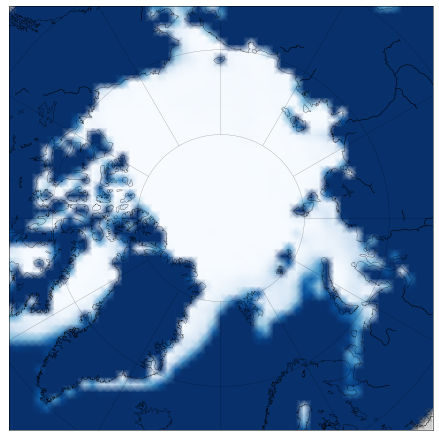

In [46]:
# File paths
#sys.path.append('../')

datapath='./SeaIce2022/'
rawdatapath='./SeaIce2022/'
dataoutpath='./DataOutput/IceConcA/'
figpath='./Figures/Arctic/IceConc/'
if not os.path.exists(rawdatapath):
	os.makedirs(os.path.join(rawdatapath))
if not os.path.exists(dataoutpath):
	os.makedirs(os.path.join(dataoutpath))
if not os.path.exists(figpath):
	os.makedirs(os.path.join(figpath))

# Get map projection and create regularly spaced grid from this projection
m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l'  )
dx_res = 100000.
grid_str=str(int(dx_res/1000))+'km'
poleStr='A'

concVersion='' # Gridded conc version string (default empty)
hemStr='N' # Hemipshere (N or S)
yearsT=2022 # Year
fmonth=4 #6=June, 9=Sep #  Forecast month

xptsG, yptsG, iceConcG = get_conc_gridded(dataoutpath, yearsT, fmonth, hemStr, concVersion=concVersion)

fig = plt.figure(figsize=(6,6))
ax1=gca()


m.pcolormesh(xptsG , yptsG, iceConcG, cmap=cm.Blues_r, vmin=0, vmax=1,shading='gouraud', zorder=2)

m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)
m.fillcontinents()

subplots_adjust( right = 0.99, left = 0.01, top=0.99, bottom=0.01)
plt.show()

In [47]:
#model kaydı
lonsG, latsG = m(xptsG, yptsG, inverse=True)

lonsG.dump(dataoutpath+'lons'+grid_str+poleStr)
latsG.dump(dataoutpath+'lats'+grid_str+poleStr)

conc_nc = Dataset(dataoutpath+'iceConc'+grid_str+str(fmonth)+poleStr+'.nc','w',format='NETCDF4_CLASSIC')
x = conc_nc.createDimension('x', 57)
y = conc_nc.createDimension('y', 57)
latitude = conc_nc.createVariable('latitude', np.float32,('x','y'))
longitude = conc_nc.createVariable('longitude', np.float32,('x','y'))
concentration = conc_nc.createVariable('concentration', np.float32,('x','y'))

latitude[:]=latsG
longitude[:]=lonsG
concentration[:]=iceConcG


conc_nc.description = 'İce concentration data re-gridded to 100 km polar stereographic'
conc_nc.history = 'Created ' + time.ctime(time.time())
conc_nc.source = 'Gizem Öztürk'
conc_nc.close()

Gridding

Num conc files: 30  year:2022  in month:04


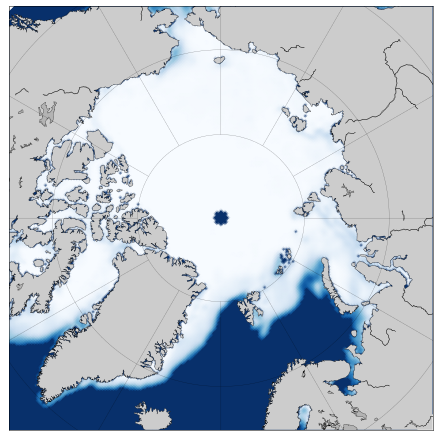

In [48]:
# Import Python libraries
#sys.path.append('../')

# REPLACE THIS WITH A REPO PATH TO A MONTHLY RAW CONC DATA FILE

# File paths
datapath='./SeaIce2022/'
rawdatapath='./SeaIce2022/'
dataoutpath='./DataOutput/IceConcA/'
figpath='./Figures/Arctic/IceConc/'
if not os.path.exists(rawdatapath):
	os.makedirs(os.path.join(rawdatapath))
if not os.path.exists(dataoutpath):
	os.makedirs(os.path.join(dataoutpath))
if not os.path.exists(figpath):
	os.makedirs(os.path.join(figpath))

####################################################################################################

# Get map projection and create regularly spaced grid from this projection
m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l'  )

dx_res = 100000. # 100 km
nx = int((m.xmax-m.xmin)/dx_res)+1; ny = int((m.ymax-m.ymin)/dx_res)+1
grid_str=str(int(dx_res/1000))+'km'
lonsG, latsG, xptsG, yptsG = m.makegrid(nx, ny, returnxy=True)
#xptsG.dump(dataoutpath+'xpts'+grid_str+poleStr)
#yptsG.dump(dataoutpath+'ypts'+grid_str+poleStr)

poleStr='A'# 'A: Arctic, AA: Antarctic
month=4 # 5=June, 0=January
year=2022

# Get lon/lats pf the ice concentration data on polar sterographic grid
lats, lons = get_psnlatslons("./Github/Data")
xpts, ypts =m(lons, lats)

f = Dataset('./Github/Data/OTHER/NIC_valid_ice_mask.N25km.01.1972-2007.nc', 'r')
ice_flag = f.variables['valid_ice_flag'][:]

alg=0 #0=Nasa team

#SN monthly, NRT:near real time data
if (year>2019):
  ice_conc = get_month_concSN_NRT(datapath, year, month, alg=alg, pole=poleStr, monthMean=1)
  # Mask values below 0.15
  ice_conc=ma.masked_where(ice_conc<=0.15, ice_conc)
elif (year>2016 and year<=2019):
	#2017-2019 arası kendi repomdan çekiyorum: monthly
	ice_conc = get_month_concSN(datapath, year, month, alg=alg, pole=poleStr)
else:
	#2016'ya kadar githubdaki repodan çekiyorum: monthly
	ice_conc = get_month_concSN('./Github/Data', year, month, alg=alg, pole=poleStr)	

# fill ice concentration data with zeroes
ice_conc = ice_conc.filled(0)

ice_conc = where((ice_flag >=1.5), 0, ice_conc)

####################################################################################################

fig = figure(figsize=(6,6))
ax1=gca()

im1 = m.pcolormesh(xpts , ypts, ice_conc, cmap=cm.Blues_r, vmin=0, vmax=1,shading='gouraud', zorder=2)

m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)
m.fillcontinents(color='0.8',lake_color='0.7', zorder=2)

subplots_adjust( right = 0.99, left = 0.01, top=0.99, bottom=0.01)
#savefig(figpath+'/Arctic_BaKa_ice_extent_map_day1.png', dpi=1000)
plt.show()

# Note the pole hole due to the incomplete satellite orbit


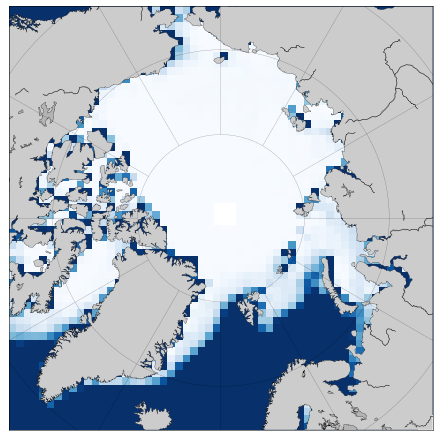

In [49]:
#remove half a degree as gridding around the pole hole edge
#SSMIS 89.18 -	January 2008 to present
#SSM/I Pole Hole Mask	87.2	July 1987 through December 2007
#SMMR Pole Hole Mask - 84.5	November 1978 through June 1987
if (year<1987):
    pmask=84.
elif((year==1987)&(month<=4)):
    pmask=84.
elif ((year==1987)&(month>4)):
    pmask=86.5
elif ((year>1987)&(year<2008)):
    pmask=86.5
else:
    pmask=88.5

# Grid data
ice_concG = griddata((xpts.flatten(), ypts.flatten()),ice_conc.flatten(), (xptsG, yptsG), method='linear')
ice_conc_ma=ma.masked_where(np.isnan(ice_concG), ice_concG)
ice_conc_ma=ma.masked_where((latsG>pmask), ice_conc_ma)

####################################################################################################

fig = figure(figsize=(6,6))
ax1=gca()

m.pcolormesh(xptsG , yptsG, ice_conc_ma, cmap=cm.Blues_r, vmin=0, vmax=1,shading='flat', zorder=2)

m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)
m.fillcontinents(color='0.8', lake_color='0.7', zorder=2)

subplots_adjust( right = 0.99, left = 0.01, top=0.99, bottom=0.01)
#savefig(figpath+'/Arctic_BaKa_ice_extent_map_day1.png', dpi=1000)
plt.show()

**FORECAST**

ForecastYears

In [50]:
def main(year, fmonth, pmonth, fvars=['conc'], iceType='extent', hemStr='N', siiVersion='v3.0', startYear=1979, weight=1, region=0, numYearsReq=5, plotForecast=1, plotSkill=1, outSkill=1, outLine=1, outWeights=1):
	""" 
	Main sea ice forecast script. Can be run here (and looped )
	Args:
		startYear=1980 # Start of forecast training
		endYear=2022 # End of forecast
		fmonth=11 #6=June, 9=Sep #  Forecast month
		pmonth=2 #9=SEP # Predicted month
		fvars: forecast variables (e.g. 'conc'). Need to be in brackets.
		weight: Spatially weighting the data (1=True)
		iceType: Ice type being forecast ('extent' or 'area')
		hemStr: Hemipshere (N or S)
		siiVersion: version of the NSIDC sea ice index (if used as the observed ice state)
		startYear: Start year of training data (default = 1980)
		region: Region being forecast (0 is pan Arctic/Antartctic)
			#0 implies pan-Arctic or Antarctic
			#2 Weddell Sea
			#3 Indian Ocean
			#4 Pacific Ocean
			#5 Ross Sea
			#6 Amundsen/BHausen Sea
			#A Alaskan
		numYearsReq: (defaul 5) Number of years required in a grid cell for it to count towards the training data
		plotSkill: =1 for plotting the skill
		outSkill: =1 far saving the skill values
		outLine: =1 for saving the forecast time series
		outWeights: =1 for saving the weightings
	Returns:
		A dumped Python array including the folowing variables:
			Observed ice extent
			Observed detrended ice extent from linear trend persistence (LTP)
			LTP extent
			Absolute forecast of sea ice extent (added LTP)
			Detrended (forecast) ice extent from LTP
			Forecast anomaly from observed
			Estimated forecast error (1 SD)
	"""
	repoPath='./SeaIce2022/'
	rawDataPath = repoPath 
	derivedDataPath = './DataOutput/'

	if (hemStr=='S'):
		saveDataPath=derivedDataPath+'Antarctic/'
		figPath='./Figures/Antarctic/YearlyPredictions'
		if  not os.path.exists(figPath):
			os.makedirs(os.path.join(figPath))  
		if  not os.path.exists(saveDataPath):
			os.makedirs(os.path.join(saveDataPath))   
	elif (hemStr=='N'):
		saveDataPath=derivedDataPath+'Arctic/'
		figPath='./Figures/Arctic/YearlyPredictions'
		if  not os.path.exists(figPath):
			os.makedirs(os.path.join(figPath))
		if  not os.path.exists(saveDataPath):
			os.makedirs(os.path.join(saveDataPath))    
	if (region=='A'):
		saveDataPath=derivedDataPath+'Alaska/'
		figPath='./Figures/Alaska/YearlyPredictions'
		if  not os.path.exists(figPath):
			os.makedirs(os.path.join(figPath)) 
		if  not os.path.exists(saveDataPath):
			os.makedirs(os.path.join(saveDataPath))   
			    

	print ('Forecast year:', year)
	print ('Forecast data month:', fmonth, 'Predicted month:', pmonth)
	print ('Variables:', fvars)
	print ('Hemisphere:', hemStr)
	print ('Ice type predicted', iceType)
	print ('Weighted:', weight)

	varStrsOut=''.join(fvars)
	outStr='forecastDump'+iceType+varStrsOut+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(year)+'W'+str(weight)+'SII'+siiVersion

	if (year<2022):
		anomObsT=1
	else:
		anomObsT=0

	forecastVals=CalcForecastMultiVar(rawdatapath, derivedDataPath, year, startYear, fvars, fmonth, pmonth=pmonth,
			region=region, anomObs=anomObsT, numYearsReq=numYearsReq, weight=weight, outWeights=outWeights,	icetype=iceType, hemStr=hemStr, siiVersion=siiVersion)	
  	
	print ('Observed ice state:', forecastVals[0])
	print ('Linear trend presistence:', forecastVals[2])
	print ('Forecast ice state:', forecastVals[3])
	print ('Detrended observed ice state :', forecastVals[1])
	print ('Detrended observed ice state :', forecastVals[4])
	print ('Forecast anomaly :', forecastVals[5])
	
	array(forecastVals).dump(saveDataPath+outStr)

	if (plotForecast==1):
		if (region==0):
			years, extent = get_ice_extentN("./SeaIce2022/", pmonth, startYear, year, 
                                   icetype=iceType, version=siiVersion, hemStr=hemStr)
			
			plotForecastOneYear(figPath, years, extent, year, forecastVals, outStr, iceType, minval=9, maxval=14)


		elif (region=='A'):
			poleStr='A'

			extent=loadtxt(derivedDataPath+'/Extent/'+'ice_'+iceType+'_M'+str(pmonth)+'R'+str(region)+'_'+str(startYear)+'2017'+poleStr)
			extent=extent[0:year-startYear+1]
			years=np.arange(startYear, startYear+size(extent), 1)

			plotForecastOneYear(figPath, years, extent, year, forecastVals, outStr, iceType, minval=9, maxval=14)	

#-- run main program
if __name__ == '__main__':
	#main(1990, 1, 5)
	for y in range(1990, 2022+1, 1):
		main(y, 4, 6, iceType='extent', hemStr='N', startYear=1979, region=0)
	#	for m in range(startMonth, endMonth+1):
	#		print (y, m)

Forecast year: 1990
Forecast data month: 4 Predicted month: 6
Variables: ['conc']
Hemisphere: N
Ice type predicted extent
Weighted: 1
1979 1989 6
anomObs
Observed ice state: 11.64
Linear trend presistence: 12.084181818181811
Forecast ice state: 12.197267185158013
Detrended observed ice state : -0.4441818181818107
Detrended observed ice state : 0.11308536697620211
Forecast anomaly : -0.5572671851580129
Forecast year: 1991
Forecast data month: 4 Predicted month: 6
Variables: ['conc']
Hemisphere: N
Ice type predicted extent
Weighted: 1
1979 1990 6
anomObs
Observed ice state: 12.11
Linear trend presistence: 11.905303030303031
Forecast ice state: 11.94856455928283
Detrended observed ice state : 0.20469696969696827
Detrended observed ice state : 0.0432615289797987
Forecast anomaly : 0.1614354407171703
Forecast year: 1992
Forecast data month: 4 Predicted month: 6
Variables: ['conc']
Hemisphere: N
Ice type predicted extent
Weighted: 1
1979 1991 6
anomObs
Observed ice state: 12.15
Linear trend 

Prediction Notebook

In [51]:
plotSkill=1 # for plotting the skill
outSkill=1 # far saving the skill values
outLine=1 # for saving the forecast time series
outWeights=1 #for saving the weightings

startYearF=1980 # Start year of forecast training
numYearsReq=5 #number of years required in a grid cell for it to count towards the training data

yearF=2021 # Forecast data year
yearP=2021 # Predicted year

fmonth=4 #6=June, 9=Sep #  Forecast month
pmonth=6 #9=SEP # Predicted month
fvars=['conc'] # Sea ice concentration='conc'. 
concVersion='' #version of the gridded ice conc files
siiVersion='v3.0'
# Can add multiple variables here, e.g. 'melt'= melt onset over sea ice
weight=1 # Spatially weighting the data, normally 1
hemStr='N' # Hemipshere (N or S)
iceType='extent' # ice type being forecast ('extent' or 'area')
alg=0

region=0
#0 implies pan-Arctic or Antarctic
#2 Weddell Sea
#3 Indian Ocean
#4 Pacific Ocean
#5 Ross Sea
#6 Amundsen/BHausen Sea
#A Alaskan

anomObs=1 # This flag means we have observed data for the forecast year.
# This needs to be set to zero if producing forecasts into the future.
# Figure paths
rawDataPath = './SeaIce2022/' 
derivedDataPath = './DataOutput/'
# Get the training data for all years prior to the given forecast year
yearsTr, extentTr = get_ice_extentN(rawDataPath, pmonth, startYearF, yearP-1, icetype=iceType, version=siiVersion, hemStr=hemStr)
# Linearly detrend the data
# NB THIS IS SOMETHING WE CAN LOOK INTO CHANGING
extentDTr, lineTr=get_varDT(yearsTr, extentTr)
print (extentTr, extentDTr)

[12.2  12.43 12.48 12.3  12.15 12.22 11.98 12.49 11.94 12.24 11.64 12.11
 12.15 11.87 12.02 11.44 12.08 11.74 11.71 11.78 11.67 11.46 11.58 11.6
 11.45 11.16 10.92 11.22 11.21 11.32 10.59 10.75 10.67 11.36 11.03 10.88
 10.41 10.76 10.78 10.59 10.59] [-0.28602787 -0.00851916  0.08898955 -0.04350174 -0.14599303 -0.02848432
 -0.22097561  0.3365331  -0.16595819  0.18155052 -0.37094077  0.14656794
  0.23407666  0.00158537  0.19909408 -0.33339721  0.3541115   0.06162021
  0.07912892  0.19663763  0.13414634 -0.02834495  0.13916376  0.20667247
  0.10418118 -0.1383101  -0.33080139  0.01670732  0.05421603  0.21172474
 -0.47076655 -0.26325784 -0.29574913  0.44175958  0.15926829  0.056777
 -0.36571429  0.03179443  0.09930314 -0.04318815  0.00432056]


In [52]:
# Generate the forecast model!
# THIS IS THE MAIN PART OF THE MODEL THAT CAN LIKELY BE IMPROVED.

# Need to get an array filled with ones to act as the intercept
predVarsTYr=[1]
predVars=np.ones((size(yearsTr)))

# Get forecast years
# Normally same as yearsTr but in case crossing year I added this to main script
#yearsFr=np.arange(startYearF, yearF, 1)

for varT in fvars:
    #print 'Var:', varT
    if (varT in ['sst','conc','melt','melt_nan', 'pmas']):

        # Get the gridded forecast data for training (prior to forecast year)
        VarYearsTr = get_gridvar(derivedDataPath, varT, fmonth, yearsTr, hemStr)

        # Get the gridded data of the forecast year
        VarYear = get_gridvar(derivedDataPath, varT, fmonth, array(yearF), hemStr)

        # Weight the gridded forecast data with training/historical sea ice data
        rvalsDT, unweightedPredVarT, predVarT, predVarTYr = GetWeightedPredVar(derivedDataPath, yearsTr, yearF, extentDTr, VarYearsTr, VarYear,varT, fmonth, pmonth, startYearF,numYearsReq, region, hemStr, iceType, normalize=0, outWeights=outWeights, weight=weight)

    # will be an array of 1 (intercept) and a number
    predVarsTYr.append(predVarTYr)
    # will be an array of 1s (intercepts) and a series of numbers
    predVars=np.column_stack((predVars, array(predVarT)))
print(predVars)

[[ 1.00000000e+00 -6.88375473e-04]
 [ 1.00000000e+00  1.90080506e-04]
 [ 1.00000000e+00  1.10887131e-03]
 [ 1.00000000e+00 -1.00881806e-03]
 [ 1.00000000e+00 -1.33229216e-03]
 [ 1.00000000e+00 -1.13107061e-03]
 [ 1.00000000e+00 -9.52928331e-04]
 [ 1.00000000e+00  9.10110308e-04]
 [ 1.00000000e+00  3.89647930e-04]
 [ 1.00000000e+00  5.93375718e-04]
 [ 1.00000000e+00 -6.08232125e-04]
 [ 1.00000000e+00  3.06094500e-04]
 [ 1.00000000e+00 -5.36056969e-04]
 [ 1.00000000e+00  2.31252476e-04]
 [ 1.00000000e+00  7.88344120e-04]
 [ 1.00000000e+00 -6.14182855e-04]
 [ 1.00000000e+00 -1.73600683e-04]
 [ 1.00000000e+00  3.68143408e-04]
 [ 1.00000000e+00  1.83542435e-03]
 [ 1.00000000e+00  1.58621423e-03]
 [ 1.00000000e+00 -1.89639956e-04]
 [ 1.00000000e+00  1.12416204e-03]
 [ 1.00000000e+00  1.16753230e-03]
 [ 1.00000000e+00  1.15928842e-03]
 [ 1.00000000e+00  7.50267193e-04]
 [ 1.00000000e+00 -7.26505620e-04]
 [ 1.00000000e+00 -1.26625525e-03]
 [ 1.00000000e+00 -1.61599121e-03]
 [ 1.00000000e+00 -5

In [53]:
# Use SM to generate the regression model. Could have just used linregress (tested, gave same results, but this was just a bit neater)
model=sm.OLS(extentDTr, predVars)
fit=model.fit()

# Forecast detrended sea ice extent!
extentForrDT = fit.predict(predVarsTYr)[0]

# Prediction uncertainty estimate
prstd, iv_l, iv_u = wls_prediction_std(fit, exog=predVarsTYr)

# Calculate alternative ice extent forecast simply assuming linear trend persistnce
extTrendP=(lineTr[-1]+(lineTr[-1]-lineTr[-2]))

extentForrAbs = extentForrDT+extTrendP

if (anomObs==1):
    # Get the extent data for the given prediction year and compare against forecast
    years, extentYrs = get_ice_extentN(rawDataPath, pmonth, startYearF, yearP, icetype=iceType, version=siiVersion, hemStr=hemStr)

    #yearsYr, extentYr = ff.getIceExtentAreaPetty(extdatapath, pmonth, startYearF, yearP, icetype=iceType, alg=0)
    extentObsDT=extentYrs[-1]-extTrendP
    anom=extentYrs-extentForrAbs
    print ('Observed extent:',extentYrs[-1])

print ('Linear trend extent:',extTrendP)
print ('Forecast extent:',extentForrAbs)

Observed extent: 10.77
Linear trend extent: 10.53817073170731
Forecast extent: 10.670478010027514


In [54]:
print(extentForrAbs)

10.670478010027514


In [55]:
print(extentObsDT)

0.2318292682926888


In [56]:
yearsFr=np.arange(startYearF, yearF, 1)
print (yearsFr)
print (predVarTYr.shape)

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
()


In [57]:
print(yearsTr)

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [58]:
print(years)

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


In [59]:
print(extentYrs)

[12.2  12.43 12.48 12.3  12.15 12.22 11.98 12.49 11.94 12.24 11.64 12.11
 12.15 11.87 12.02 11.44 12.08 11.74 11.71 11.78 11.67 11.46 11.58 11.6
 11.45 11.16 10.92 11.22 11.21 11.32 10.59 10.75 10.67 11.36 11.03 10.88
 10.41 10.76 10.78 10.59 10.59 10.77]


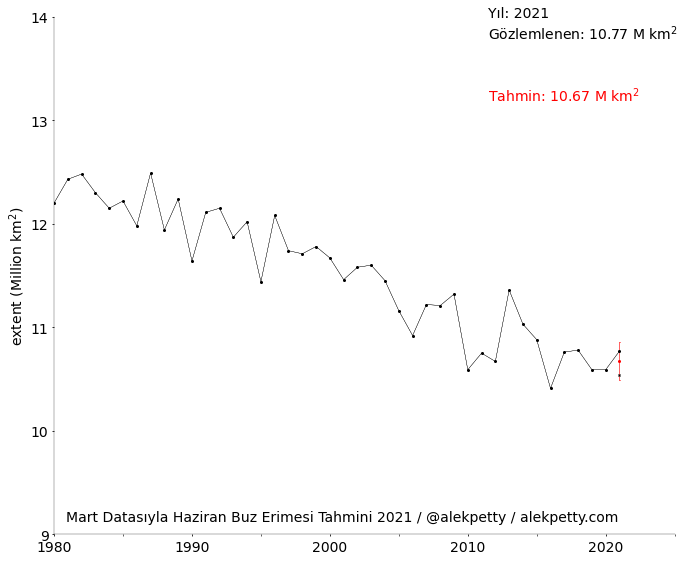

In [60]:
"""Plot forecast data """
from mpl_toolkits.basemap import Basemap, shiftgrid
# plotting parameters
rcParams['xtick.major.size'] = 2
rcParams['ytick.major.size'] = 2
rcParams['axes.linewidth'] = .3
rcParams['lines.linewidth'] = .3
rcParams['patch.linewidth'] = .3

rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize']=14
rcParams['ytick.labelsize']=14
rcParams['legend.fontsize']=14
rcParams['font.size']=14
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})


fig = plt.figure(figsize=(10,8))
ax1=subplot(1, 1, 1)
im1 = plot(years, extentYrs, 'k')
#im2 = plot(Years[start_year_pred-start_year:], lineT[start_year_pred-start_year:]+ExtentG, 'r')
#extentyr, extentObsDT, extTrendP, extentForrAbs, extentForrDT, anom, prstd[0]
im2 = plot(years, extentYrs, marker='o', markersize=2, color='k')
im3 = plot(years[-1], extTrendP, marker='x', markersize=2, color='k')
im3 = plot(years[-1], extentForrAbs, marker='o', markersize=2, color='r')
#errorbar(YearsP, array(lineTP)+array(ExtentG) , yerr=prederror, color='r',fmt='',linestyle='',lw=0.4,capsize=0.5, zorder = 2)
#if (np.isfinite(forecastVars[4])):

ax1.errorbar(years[-1], extentForrAbs , yerr=prstd[0], color='r',fmt='',linestyle='',lw=0.6,capsize=0.5, zorder = 2)
#ax1.errorbar(yearsP, extentPredAbs , yerr=[1.96*x for x in perr], color='r',fmt='',linestyle='',lw=0.3,capsize=0.5, zorder = 2)

forecastStr='%.2f' %(extentForrAbs)
observedStr='%.2f' %(extentYrs[-1])

ax1.annotate('Yıl: '+str(years[-1])+'\nGözlemlenen: '+observedStr+r' M km$^2$',
    xy=(0.7, 1.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

ax1.annotate('\nTahmin: '+forecastStr+r' M km$^2$',
    xy=(0.7, 0.9), xycoords='axes fraction', color='r', horizontalalignment='left', verticalalignment='top')

ax1.annotate('Mart Datasıyla Haziran Buz Erimesi Tahmini 2021 / @alekpetty / alekpetty.com', 
    xy=(0.02, 0.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom')

ax1.set_ylabel(iceType+r' (Million km$^2$)')
#ax1.set_xlabel('Years')
ax1.set_xlim(1980, 2025)
ax1.set_xticks(np.arange(1980, 2026, 10))
ax1.set_xticks(np.arange(1980, 2026, 5), minor=True)
#ax1.set_xticklabels([])
ax1.set_ylim(9, 14)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

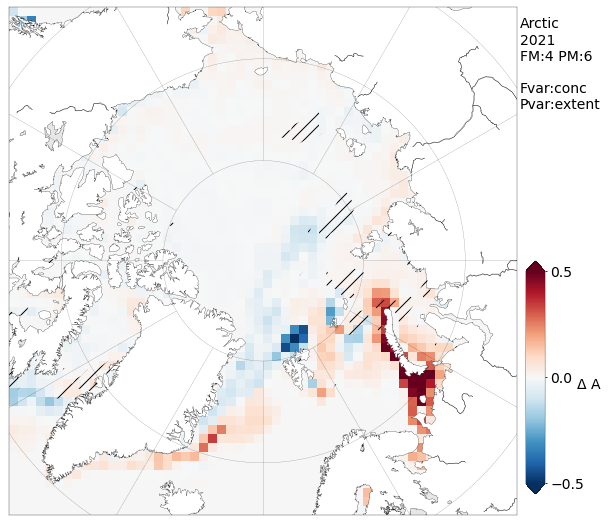

In [61]:
# plot forecast anomaly field that drove the forecast
minval=-0.5
maxval=0.5

if (hemStr=='N'):
    if ((region=='A')):
        regionOut='Alaska'
    else:
        regionOut='Arctic'
else:
    regionOut='Antarctic'

# Map projection
m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l'  )

# Gridded coordinates
hemStr='N'
if (hemStr=='S'):
	poleStr='AA'
elif (hemStr=='N'):
	poleStr='A'

xpts=load(derivedDataPath+'IceConcA/'+concVersion+'/xpts100km'+poleStr,allow_pickle=True)
ypts=load(derivedDataPath+'IceConcA/'+concVersion+'/ypts100km'+poleStr,allow_pickle=True)
fig = figure(figsize=(9,9*0.8))
ax=gca()

im1 = m.contourf(xpts , ypts, rvalsDT,levels=[0.3, 0.8], colors='none', hatches=['//'], zorder=3)

im2 = m.pcolormesh(xpts, ypts, unweightedPredVarT,vmin=minval, vmax=maxval, cmap=cm.RdBu_r, shading='interp', zorder=2)
#im1 = m.pcolormesh(xpts , ypts, rvals, cmap=cm.cubehelix, vmin=minval, vmax=maxval,shading='flat', zorder=2)

m.fillcontinents(color='w',lake_color='0.9', zorder=2)
m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)

label_str=r'$\Delta$ A'
cax = fig.add_axes([0.81, 0.05, 0.03, 0.45])
cbar = colorbar(im2,cax=cax, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label(label_str, labelpad=4, rotation=0)
cbar.set_ticks(np.linspace(minval, maxval, 3))
cbar.solids.set_rasterized(True)

#ax.annotate(varStr, xy=(0.5, 1.01),xycoords='axes fraction', horizontalalignment='center', verticalalignment='bottom', zorder=10)
ax.annotate(regionOut+'\n'+str(yearP)+'\nFM:'+str(fmonth)+' PM:'+str(pmonth)+'\n\nFvar:'+fvars[0]+'\nPvar:'+iceType, xy=(1.005, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', rotation=0, zorder=10)

subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.8)
plt.show()
#savefig(figpath+'anomaly'+varStr+iceType+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(yearT)+poleStr+'.png', dpi=300)
#close(fig)

***PLOTTİNG***

PlotAnomalyA

In [62]:
rcParams['xtick.major.size'] = 2
rcParams['ytick.major.size'] = 2
rcParams['axes.linewidth'] = .3
rcParams['lines.linewidth'] = .3
rcParams['patch.linewidth'] = .3

rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize']=8
rcParams['ytick.labelsize']=8
rcParams['legend.fontsize']=8
rcParams['font.size']=8
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l'  )

figpath='./Figures/Arctic/Anomalies/'
dataoutpath='./DataOutput'
if not os.path.exists(figpath):
	os.makedirs(os.path.join(figpath))
 
startYear=1979
yearT=2022
fmonth=4 #6=june
pmonth=6 #6=june

hemStr='N'
if (hemStr=='S'):
	weightsdataoutpath=dataoutpath+'/Antarctic/'
	poleStr='AA'
elif (hemStr=='N'):
	weightsdataoutpath=dataoutpath+'/Arctic/'
	poleStr='A'

#xpts, ypts, Melt_onset_years =pfuncs.get_meltonset(m, data_path, 'melt_onset', -0.5, 0, 0, str(start_year), str(end_year))

xpts=load(dataoutpath+'/IceConcA/xpts100km'+poleStr, allow_pickle=True)
ypts=load(dataoutpath+'/IceConcA/ypts100km'+poleStr, allow_pickle=True)

varStr='conc'
icetype='extent'
region=0

if ((region=='A')):
	regionOut='Alaska'
	weightsdataoutpath=dataoutpath+'/Alaska/'
else:
	regionOut='Arctic'


r_valsDT=load(weightsdataoutpath+'rvalsDT'+varStr+icetype+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(yearT)+'.txt', allow_pickle=True)
predvarDT=load(weightsdataoutpath+'predvarYrDT'+varStr+icetype+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(yearT)+'.txt', allow_pickle=True)


minval=-0.5
maxval=0.5


fig = figure(figsize=(3,3*0.8))
ax=gca()

im1 = m.contourf(xpts , ypts, r_valsDT,levels=[0.25, 1.], colors='none', hatches=['///'], zorder=4)
	
im2 = m.pcolormesh(xpts, ypts, predvarDT,vmin=minval, vmax=maxval, cmap=cm.RdBu_r, shading='interp', zorder=2)
#im1 = m.pcolormesh(xpts , ypts, rvals, cmap=cm.cubehelix, vmin=minval, vmax=maxval,shading='flat', zorder=2)

m.fillcontinents(color='w',lake_color='0.9', zorder=2)
m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)

label_str=r'$\Delta$ A'
cax = fig.add_axes([0.81, 0.05, 0.03, 0.45])
cbar = colorbar(im2,cax=cax, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label(label_str, labelpad=4, rotation=0)
cbar.set_ticks(np.linspace(minval, maxval, 3))
cbar.solids.set_rasterized(True)

#ax.annotate(varStr, xy=(0.5, 1.01),xycoords='axes fraction', horizontalalignment='center', verticalalignment='bottom', zorder=10)
ax.annotate(regionOut+'\n'+str(yearT)+'\nFM:'+str(fmonth)+' PM:'+str(pmonth)+'\n\nFvar:'+varStr+'\nPvar:'+icetype, xy=(1.005, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', rotation=0, zorder=10)

subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.8)
savefig(figpath+'anomaly'+varStr+icetype+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(yearT)+poleStr+'.png', dpi=300)
close(fig)

PlotForecasts

In [ ]:
def main(endYear, fmonth, pmonth, fvars=['conc'], iceType='extent', hemStr='N', siiVersion='v3.0', startYear=1979, minval=3, maxval=8, region=0):
	
	monthStrs=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'August', 'September']
	textStr=monthStrs[fmonth-1]+' forecasts of '+monthStrs[pmonth-1]+' Arctic sea ice '+iceType

	repoPath='./SeaIce2022/'
	rawDataPath = repoPath 
	derivedDataPath = './DataOutput/'
	if (hemStr=='S'):
		saveDataPath=derivedDataPath+'/Antarctic/'
		figPath='./Figures/Forecasts/'
		if  not os.path.exists(figPath):
			os.makedirs(os.path.join(figPath))  
		if  not os.path.exists(saveDataPath):
			os.makedirs(os.path.join(saveDataPath))   
	elif (region=='A'):
		saveDataPath=derivedDataPath+'/Alaska/'
		figPath='./Figures/Forecasts/'
		if  not os.path.exists(figPath):
			os.makedirs(os.path.join(figPath))  
		if  not os.path.exists(saveDataPath):
			os.makedirs(os.path.join(saveDataPath))   
	else:
		saveDataPath=derivedDataPath+'/Arctic/'
		figPath='./Figures/Forecasts/'
		if  not os.path.exists(figPath):
			os.makedirs(os.path.join(figPath))  
		if  not os.path.exists(saveDataPath):
			os.makedirs(os.path.join(saveDataPath))   	
	
	startYearP=1990
	#endYear=2021
	weight=1

	varStrsOut=''.join(fvars)
	forecastVarsM=np.array([]).reshape(0,7)

	for year in range(startYearP, endYear+1):
		outStr='forecastDump'+iceType+varStrsOut+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(year)+'W'+str(weight)+'SII'+siiVersion

		forecastVars=load(saveDataPath+outStr, allow_pickle=True)
		forecastVarsM=np.vstack([forecastVarsM, forecastVars])

	if (region==0):
		years, extent = get_ice_extentN(rawDataPath, pmonth, startYear, year, 
			icetype=iceType, version=siiVersion, hemStr=hemStr)
	elif (region=='A'):
		poleStr='A'

		extent=loadtxt(derivedDataPath+'/Extent/'+'ice_'+iceType+'_M'+str(pmonth)+'R'+str(region)+'_'+str(startYear)+'2017'+poleStr, allow_pickle=True)
		#extent=extent[0:year-startYear+1]
		years=np.arange(startYear, 2021+1, 1)

	yearsP=np.arange(startYearP, endYear+1)

	#extentyr, extentObsDT, extTrendP, extentForrAbs, extentForrDT, anom, prstd[0]
	print ('Prediction int:', forecastVars[-1])

	skill = '%.2f' %(1 - (rms(forecastVarsM[0:-1, 5]))/(rms(forecastVarsM[0:-1, 1])))

	"""Plot forecast data """
	rcParams['xtick.major.size'] = 2
	rcParams['ytick.major.size'] = 2
	rcParams['axes.linewidth'] = .5
	rcParams['lines.linewidth'] = .5
	rcParams['patch.linewidth'] = .5
	rcParams['axes.labelsize'] = 8
	rcParams['xtick.labelsize']=8
	rcParams['ytick.labelsize']=8
	rcParams['legend.fontsize']=8
	rcParams['font.size']=7
	rc('font',**{'family':'sans-serif','sans-serif':['Arial']})


	fig = figure(figsize=(4.,2.2))
	ax1=subplot(1, 1, 1)
	im1 = plot(years, extent, 'k')
	#im2 = plot(Years[start_year_pred-start_year:], lineT[start_year_pred-start_year:]+ExtentG, 'r')

	#im3 = plot(years[-1], extent[-1], marker='o', markersize=2, color='k')
	im3 = plot(yearsP, forecastVarsM[:, 2], marker='x', markersize=1, alpha=0.5, color='k')
	im3 = plot(yearsP, forecastVarsM[:, 3], marker='o', markersize=1, alpha=0.5, color='r')
	#ax1.errorbar(yearsP, forecastVarsM[:, 3] , yerr=forecastVarsM[:, 6], color='r',fmt='',linestyle='',alpha=0.5, lw=0.6,capsize=0.5, zorder = 2)

	im3 = plot(yearsP[-1], forecastVarsM[-1, 2], marker='x', markersize=2, color='k')
	im3 = plot(yearsP[-1], forecastVarsM[-1, 3], marker='o', markersize=2, color='r')
	ax1.errorbar(yearsP[-1], forecastVarsM[-1, 3] , yerr=forecastVarsM[-1, 6], color='r',fmt='',linestyle='',lw=0.6,capsize=0.5, zorder = 2)

	#errorbar(YearsP, array(lineTP)+array(ExtentG) , yerr=prederror, color='r',fmt='',linestyle='',lw=0.4,capsize=0.5, zorder = 2)
	#if (np.isfinite(forecastVars[4])):

	#ax1.errorbar(yearsP, extentPredAbs , yerr=[1.96*x for x in perr], color='r',fmt='',linestyle='',lw=0.3,capsize=0.5, zorder = 2)

	forecastStr='%.2f' %(forecastVarsM[-1, 3])
	linearStr='%.2f' %(forecastVarsM[-1, 2])
	#observedStr='%.2f' %(extent[-1])

	ax1.annotate('Yıl: '+str(year)+'\nLinear trend forecast: '+linearStr+r' M km$^2$',
			xy=(0.8, 1.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

	ax1.annotate('NASA GSFC forecast: '+forecastStr+r' M km$^2$',
			xy=(0.8, 0.9), xycoords='axes fraction', color='r', horizontalalignment='left', verticalalignment='top')

	#ax1.annotate('Year: '+str(year)+'\nObserved: '+observedStr+r' M km$^2$'+'\nTrend: '+linearStr+r' M km$^2$',
	#		xy=(1., 1.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

	#ax1.annotate(,
	#		xy=(0.8, 0.85), xycoords='axes fraction', color='r', horizontalalignment='left', verticalalignment='top')

	#ax1.annotate('NASA GSFC forecast: '+forecastStr+r' M km$^2$'+'\nSkill:'+skill,
	#		xy=(0.8, 0.85), xycoords='axes fraction', color='r', horizontalalignment='left', verticalalignment='top')

	ax1.annotate(textStr, fontsize=5, 
			xy=(0.02, 0.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom')

	ax1.set_ylabel('Ice '+iceType+r' (Million km$^2$)')
	#ax1.set_xlabel('Years')
	ax1.set_xlim(1980, 2025)
	ax1.set_xticks(np.arange(1980, 2026, 10))
	ax1.set_xticks(np.arange(1980, 2026, 5), minor=True)
	#ax1.set_xticklabels([])
	ax1.set_ylim(minval, maxval-0.1)
	ax1.set_yticks(np.arange(minval, maxval, 1))

	ax1.spines['right'].set_visible(False)
	ax1.spines['top'].set_visible(False)

	ax1.yaxis.grid(which='major', linestyle='-', linewidth='0.1', color='k')
	#plt.tight_layout()
	#subplots_adjust(left=0.15, right=0.90, bottom=0.17, top=0.96, hspace=0)
	subplots_adjust(left=0.11, right=0.74, bottom=0.1, top=0.96, hspace=0)

	savefig(figPath+'/'+outStr+hemStr+'multi.png', dpi=300)
	savefig(figPath+'/'+outStr+hemStr+'multi.jpg', dpi=300)
	close(fig)


#-- run main program
if __name__ == '__main__':
	#main(2015, 6, 9)
	for y in range(1990, 2022+1, 1):
		main(y, 4, 6, iceType='extent', hemStr='N', minval=9, maxval=14, region=0, startYear=1979)

AnimateForecast

In [ ]:
import imageio as iio
#png_dir ="./Figures/Arctic/YearlyPredictions"
png_dir ="./Figures/Forecasts/"

images = []
for subdir, dirs, files in os.walk(png_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        if file_path.endswith("multi.png"):
            images.append(imageio.imread(file_path))
kargs = { 'duration': 5, 'loop':1 }
imageio.mimsave(png_dir+'/animatedForecasts.gif', images, loop=2)
imageio.mimsave(png_dir+'/animatedForecasts.mp4', images)


In [ ]:
!zip -r ./figures.zip ./Figures
#for save the folder

In [ ]:
!zip -r ./dataoutput.zip ./DataOutput
#for save the folder

STATMODELS

https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.html

In [93]:
#model=sm.OLS(extentDTr, predVars)
#fit=model.fit()
results = fit

In [71]:
results.tvalues
print(results.t_test([1, 0]))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          2.127e-15      0.028    7.6e-14      1.000      -0.057       0.057


In [96]:
print("The model degree of freedom: ",results.df_model)
print("The residual degree of freedom: ",results.df_resid)


The model degree of freedom:  1.0
The residual degree of freedom:  39.0


In [105]:
print( "White's (1980) heteroskedasticity robust standard errors: ", results.HC0_se )
print( "MacKinnon and White's (1985) heteroskedasticity robust standard errors: ", results.HC1_se )

print( "Akaike's information criteria: ", results.aic)
print( "Bayes' information criteria: ", results.bic)
print( "The standard errors of the parameter estimates: ", results.bse)

print("The total (weighted) sum of squares centered about the mean: ",results.centered_tss)

White's (1980) heteroskedasticity robust standard errors:  [ 0.02729845 22.68494226]
MacKinnon and White's (1985) heteroskedasticity robust standard errors:  [ 0.02798966 23.2593355 ]
Akaike's information criteria:  -22.666475741725307
Bayes' information criteria:  -19.23933160831669
The standard errors of the parameter estimates:  [2.79896556e-02 2.86354147e+01]
The total (weighted) sum of squares centered about the mean:  1.8921696864111563


In [104]:
print("Return condition number of exogenous matrix:",results.condition_number)

print("Heteroscedasticity robust covariance matrix:\n",results.cov_HC0,"\n")
print("Heteroscedasticity robust covariance matrix:\n",results.cov_HC1,"\n")
print("Return eigenvalues sorted in decreasing order: ",results.eigenvals,"\n")
print("The explained sum of squares: ",results.ess,"\n")

print("Mean squared error the model: ",results.mse_model)
print("Mean squared error of the residuals: ",results.mse_resid)
print("The total mse ",results.mse_total,"\n")

print("R-squared of the model:",results.rsquared)
print("Adjusted R-squared: ",results.rsquared_adj)
print("Sum of squared (whitened) residuals: ",results.ssr)
print("Uncentered sum of squares: ",results.uncentered_tss,"\n")

print("Number of observations n: ",results.nobs)
print("Return the t-statistic for a given parameter estimate: ",results.tvalues)
print("The two-tailed p values for the t-stats of the params: ",results.pvalues,"\n")
print("The residuals of the model: ","\n",results.resid,"\n")
print("Residuals, normalized to have unit variance: ","\n",results.resid_pearson,"\n")

print("The p-value of the F-statistic: ",results.f_pvalue,"\n")
print("The predicted values for the original (unwhitened) design: ","\n",results.fittedvalues,"\n")
print("F-statistic of the fully specified model:",results.fvalue)
print("Log-likelihood of model: ",results.llf,"\n")

print("The residuals of the transformed/whitened regressand and regressor(s): ","\n",results.wresid)

Return condition number of exogenous matrix: 1023.0713500036475
Heteroscedasticity robust covariance matrix:
 [[7.45205171e-04 8.72455267e-03]
 [8.72455267e-03 5.14606605e+02]] 

Heteroscedasticity robust covariance matrix:
 [[7.83420821e-04 9.17196563e-03]
 [9.17196563e-03 5.40996688e+02]] 

Return eigenvalues sorted in decreasing order:  [4.10000000e+01 3.91716631e-05] 

The explained sum of squares:  0.6394797943217434 

Mean squared error the model:  0.6394797943217434
Mean squared error of the residuals:  0.03212025364331828
The total mse  0.04730424216027891 

R-squared of the model: 0.3379611241603987
Adjusted R-squared:  0.32098576836963977
Sum of squared (whitened) residuals:  1.252689892089413
Uncentered sum of squares:  1.8921696864111563 

Number of observations n:  41.0
Return the t-statistic for a given parameter estimate:  [7.59812731e-14 4.46194210e+00]
The two-tailed p values for the t-stats of the params:  [1.00000000e+00 6.72388819e-05] 

The residuals of the model: 

In [106]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     19.91
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           6.72e-05
Time:                        14:09:27   Log-Likelihood:                 13.333
No. Observations:                  41   AIC:                            -22.67
Df Residuals:                      39   BIC:                            -19.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.127e-15      0.028    7.6e-14      1.0

In [110]:
#model=sm.OLS(extentDTr, predVars)
#fit=model.fit()
#prstd, iv_l, iv_u = wls_prediction_std(fit, exog=predVarsTYr)
#netcdf

Parameters:  [2.12668967e-15 1.27769563e+02]
R2:  0.3379611241603987


In [113]:
print('Predicted values: \n', results.predict())

Predicted values: 
 [-0.08795343  0.0242865   0.14168    -0.12889624 -0.17022639 -0.1445164
 -0.12175524  0.1162844   0.04978515  0.07581536 -0.07771355  0.03910956
 -0.06849176  0.02954703  0.10072638 -0.07847387 -0.02218088  0.04703752
  0.23451137  0.2026699  -0.02423021  0.14363369  0.14917509  0.14812177
  0.09586131 -0.09282531 -0.16178888 -0.20647449 -0.00680643  0.12884691
  0.06539656 -0.14612375 -0.20126061  0.14280041 -0.06881584  0.027157
 -0.3069291  -0.07973364  0.07037461  0.09617394  0.06620158]
